# Preparación de los datos

## Cargar base de datos extraida


In [1]:
import pandas as pd

Vamos a cargar la base de datos completa con todas las variables ya extraidas

In [2]:
base_completa_ex =  pd.read_pickle('Outputs/df_completa_extraido_v4.p', 'gzip')
base_completa_ex.shape

(22322, 32)

Unimos la columna con el grupo de cada topografía

In [3]:
base_completa_ex["Grupo"] = pd.read_pickle('Outputs/grupo.p', 'gzip')

In [4]:
base_completa_ex = base_completa_ex.reset_index()
base_completa_ex.columns


Index(['origen', 'cod', 'fecha_nacimiento', 'edad', 'val_fecha',
       'val_operador', 'micro', 'macro', 'diagnostico', 'tipo_examen', 'Grupo',
       'topografia', 'morfologia', 'lateralidad', 'comportamiento',
       'procedimiento', 'solido', 'hemato', 'grado', 'lymph', 'linfocitaria',
       'margenes', 'tamanho', 'pTNM', 'metastasis', 'examinados', 'positivos',
       'hueso', 'cerebro', 'distantes', 'higado', 'pulmon', 'otras'],
      dtype='object')

Filtramos unicamente los tumores sólidos de los grupos deseados

In [5]:
base_ex = base_completa_ex.query(' solido != "0: No es un tumor sólido" and Grupo != "Otro"') 
base_ex.shape

(13198, 33)

In [6]:
base_ex.Grupo.value_counts()

Mama                          3385
Tracto Gastrointestinal       2717
Cabeza y cuello               2101
Melanoma y tejidos blandos    1688
Genitourinario                1500
Pulmón y bronquios             978
Ginecológico                   829
Name: Grupo, dtype: int64

## Unir estado vital y fecha de último contacto

Estado vital (0 vivo, 1 muerto) y la fecha de ultimo contacto 
que para el caso de los vivos corresponde a la fecha en la que por ultima vez se realizo seguimiento clínico a estos pacientes en la FVL,
mientras que para los muertos corresponde a la fecha de defunción.


In [7]:
info_vital = pd.read_excel('Data/info_vital-9-8-2020.xlsx', na_values='Paciente no esta en SAP')

In [8]:
info_vital.rename(columns={'CÓDIGO ÚNICO': 'cod', 
                           'ESTADO VITAL: 1-MUERTO; 0-VIVO': 'muerto',
                           'FECHA ULTIMO CONTACTO': 'fecha_final'
                       },inplace = True)
info_vital.columns

Index(['cod', 'fecha_final', 'muerto'], dtype='object')

In [9]:
info_vital['fecha_final'] = pd.to_datetime(info_vital.fecha_final, errors='coerce')
info_vital = info_vital.astype({'cod': 'string',
                                'muerto': 'boolean',
                               # 'fecha_final': 'datetime64'
})
info_vital.shape

(9709, 3)

In [10]:
base = pd.merge(base_ex, info_vital, how='inner', on='cod')
base.shape

(13198, 35)

## Pacientes con multiples registros

In [11]:
s = base.cod.value_counts()
s.value_counts()

1     7030
2     2064
3      474
4      108
5       20
6        9
7        2
8        1
10       1
Name: cod, dtype: Int64

In [12]:
idx = base.duplicated('cod', keep=False)
base[idx].groupby(['cod','Grupo']).size()

cod         Grupo                  
1001606950  Ginecológico               2
1003095704  Pulmón y bronquios         2
1003241503  Tracto Gastrointestinal    2
1003274633  Ginecológico               2
10048645    Tracto Gastrointestinal    2
                                      ..
NX9934      Mama                       3
NXLF18      Genitourinario             1
            Tracto Gastrointestinal    1
NY9761      Mama                       2
PAG742      Tracto Gastrointestinal    4
Length: 3074, dtype: int64

Añadimos una nueva columna con la fecha del diagnostico

In [13]:
base["val_fecha_def"] = base.groupby(["cod", "Grupo"])["val_fecha"].transform("min")
base["val_fecha_def"] 

0       2014-01-07
1       2014-01-07
2       2014-01-07
3       2014-01-08
4       2014-01-07
           ...    
13193   2019-11-13
13194   2019-11-08
13195   2019-11-13
13196   2019-11-09
13197   2019-11-09
Name: val_fecha_def, Length: 13198, dtype: datetime64[ns]

## Definición del tiempo de sobrevida

In [14]:
base["sobrevida"] = (base["fecha_final"] - base["val_fecha_def"]).astype('timedelta64[M]')

In [15]:
(base["sobrevida"] < 0).value_counts(dropna=False)

False    12775
True       423
Name: sobrevida, dtype: int64

## Validación y depuración de los datos

In [16]:
base.head()

,origen,cod,fecha_nacimiento,edad,val_fecha,val_operador,micro,macro,diagnostico,tipo_examen,...,hueso,cerebro,distantes,higado,pulmon,otras,fecha_final,muerto,val_fecha_def,sobrevida
0,JCB 1,6753803,NaT,80,2014-01-07,"CARLOS JIMENEZ, M.D.",TUMOR PELVIS RENAL En los cortes histológicos...,En formalina se recibe por separado y rotulad...,A: TUMOR PELVIS RENAL: BIOPSIA CARCINOMA UROT...,ESPECÍMENES QUIRÚRGICOS,...,9: se desconoce,9: se desconoce,9: se desconoce,9: se desconoce,9: se desconoce,9: se desconoce,2017-12-19,True,2014-01-07,47.0
1,JCB 15,6753803,NaT,80,2014-01-14,"CARLOS JIMENEZ, M.D.",En los cortes histológicos teñidos con HyE se...,En formol se recibe producto de nefrectomía d...,,ESPECÍMENES QUIRÚRGICOS,...,9: se desconoce,9: se desconoce,9: se desconoce,9: se desconoce,9: se desconoce,9: se desconoce,2017-12-19,True,2014-01-07,47.0
2,ERP2014 641,6753803,1932-07-18,82,2014-12-22,ANA M ARRUNATEGUI,DESCRIPCION MICROSCOPICA En los cortes histo...,DESCRIPCION MACROSCOPICA: En un frasco con fo...,DIAGNOSTICO Vejiga-lesión-biopsia CARCINOMA...,ESPECIMEN QUIRURGICO,...,9: se desconoce,9: se desconoce,9: se desconoce,9: se desconoce,9: se desconoce,9: se desconoce,2017-12-19,True,2014-01-07,47.0
3,JCB 2,32220025,NaT,59,2014-01-08,"LUIS ALBERTO ESCOBAR, M.D.",Se reconoce lesion neoplasica maligna de orig...,En formol se reciben 4 fragmentos de tejido b...,Pulmón- Masa - Biopsia. - Carcinoma de Celula...,ESPECÍMENES QUIRÚRGICOS,...,9: se desconoce,9: se desconoce,9: se desconoce,9: se desconoce,8: no aplicable,9: se desconoce,2014-01-16,True,2014-01-08,0.0
4,JCB 5,29420191,NaT,72,2014-01-07,"CARMENZA MACIA, M.D.",A. La muestra corresponde a piel comprometida...,En formol rotulado con el nombre de la pacien...,A. Piel de región supraescapular izquierda – ...,ESPECÍMENES QUIRÚRGICOS,...,9: se desconoce,9: se desconoce,9: se desconoce,9: se desconoce,9: se desconoce,9: se desconoce,2019-12-04,False,2014-01-07,70.0


In [19]:
base_f = base.query('80 > sobrevida > 0').set_index(['origen','cod'])
base_f.shape

(11539, 35)

# Descripción de los datos

In [20]:
base_f.columns

Index(['fecha_nacimiento', 'edad', 'val_fecha', 'val_operador', 'micro',
       'macro', 'diagnostico', 'tipo_examen', 'Grupo', 'topografia',
       'morfologia', 'lateralidad', 'comportamiento', 'procedimiento',
       'solido', 'hemato', 'grado', 'lymph', 'linfocitaria', 'margenes',
       'tamanho', 'pTNM', 'metastasis', 'examinados', 'positivos', 'hueso',
       'cerebro', 'distantes', 'higado', 'pulmon', 'otras', 'fecha_final',
       'muerto', 'val_fecha_def', 'sobrevida'],
      dtype='object')

In [21]:
base_f["Grupo"].value_counts()

Mama                          3162
Tracto Gastrointestinal       2203
Cabeza y cuello               1894
Melanoma y tejidos blandos    1518
Genitourinario                1337
Pulmón y bronquios             723
Ginecológico                   702
Name: Grupo, dtype: int64

In [24]:
s = base_f.query("Grupo == 'Pulmón y bronquios'")['morfologia'].value_counts()
s [s > 5 ]

Carcinoma De Célula No Pequeña                  54
Adenocarcinoma Primario Pulmonar De Patrón      33
Carcinoma De Células Escamosas Mal              20
Adenocarcinoma De Origen Pulmonar               17
Adenocarcinoma Primario Pulmonar                12
Carcinoma Ihc Score Algorithm For               12
Adenocarcinoma De Patrón Cribiforme Primario    10
Carcinoma                                        8
Carcinoma De Células Grandes Primario            7
Carcinoma De Pulmón De Célula                    7
Adenocarcinoma De Origen Primario Pulmonar       7
Adenocarcinoma Primario Del Pulmón De            7
Carcinoma Neuroendocrino De Célula Grande        6
Células Se Realiza En 500                        6
Name: morfologia, dtype: int64

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

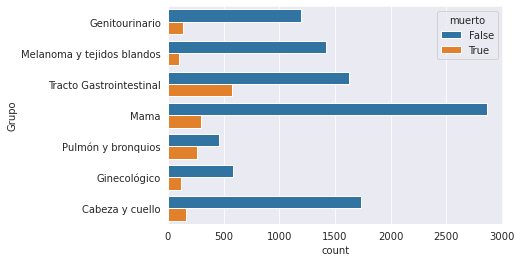

In [26]:
#fig, ax = plt.figure()
ax = sns.countplot(data=base_f, y='Grupo', hue='muerto')
plt.savefig('Outputs/grupos.png',bbox_inches='tight')

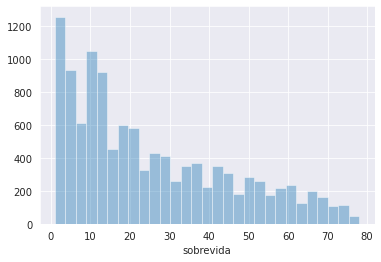

In [27]:
#fig, ax = plt.figure()
ax = sns.distplot( a=base_f['sobrevida'],kde=False,hist=True)
plt.savefig('Outputs/sobrevida.png',bbox_inches='tight')

## Preprocesamiento de variables

In [29]:
categoricas = ['grado', 'lymph', 'margenes', 'hueso', 'cerebro', 'distantes', 'higado','pulmon', 'otras',]
numericas = ['edad',]
ganglios = ['examinados', 'positivos', ]
especiales = ['tamanho', 'pTNM', ] 

In [36]:
base_f_d = pd.get_dummies(base_f[categoricas],drop_first=False)
base_f_d = base_f_d.drop(columns=base_f_d.columns[base_f_d.columns.str.contains('9')])
base_f_d.dtypes

grado_1: bien diferenciado                 uint8
grado_2: moderadamente diferenciado        uint8
grado_3: mal diferenciado                  uint8
grado_4: indiferenciado                    uint8
lymph_0: ausente                           uint8
lymph_1: presente                          uint8
margenes_0: sin tumor residual             uint8
margenes_1: tumor residual; NOS            uint8
margenes_2: tumor residual microscópico    uint8
margenes_3: tumor residual macroscópico    uint8
hueso_0: no metástasis                     uint8
hueso_1: metastasís                        uint8
cerebro_0: no metástasis                   uint8
cerebro_1: metastasís                      uint8
cerebro_8: no aplicable                    uint8
distantes_0: no metástasis                 uint8
distantes_1: metastasís                    uint8
distantes_8: no aplicable                  uint8
higado_0: no metástasis                    uint8
higado_1: metastasís                       uint8
higado_8: no aplicab

In [69]:
base_f_n = base_f[numericas + ganglios].apply(lambda s:pd.to_numeric(s,errors='coerce'), axis='columns')
base_f_n = base_f_n.fillna(-1)
base_f_n.dtypes

edad          float64
examinados    float64
positivos     float64
dtype: object

# Análisis de supervivencia


In [70]:
X = pd.concat([base_f_d,base_f_n],axis="columns")
T = base_f['sobrevida']
E = base_f['muerto']

In [55]:
idx = base_f.index
idx_gastro = base_f.query('Grupo == "Tracto Gastrointestinal"').index
idx_mama = base_f.query('Grupo == "Mama"').index


In [71]:
grupos = base_f['Grupo'].unique()
idxs = {g :idx[base_f['Grupo'] == g] for g in grupos}
# idxs

In [ ]:
print(X.shape)
X.dtypes

In [ ]:
X.describe()

In [ ]:
T.plot.hist()

In [ ]:
E.value_counts().plot.bar()

## Estimador de Kaplan Meier

In [40]:
from lifelines import KaplanMeierFitter, NelsonAalenFitter

In [48]:
km_total = KaplanMeierFitter()
km_total.fit(T,E, label='Total' )

/home/johan/anaconda3/envs/FVL/lib/python3.8/site-packages/lifelines/utils/__init__.py:1173: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


<lifelines.KaplanMeierFitter:"Total", fitted with 11539 total observations, 9882 right-censored observations>

In [51]:
km_gastro = KaplanMeierFitter()
km_gastro.fit(T[idx_gastro],E[idx_gastro], label='Gastrico' )

NameError: name 'idx_gastro' is not defined

In [52]:
km_mama = KaplanMeierFitter()
km_mama.fit(T[idx_mama],E[idx_mama], label='Mama' )

NameError: name 'idx_mama' is not defined

AttributeError: 'KaplanMeierFitter' object has no attribute 'survival_function_'

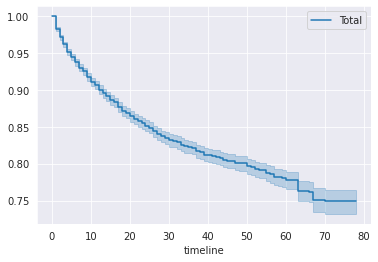

AttributeError: 'KaplanMeierFitter' object has no attribute 'survival_function_'

In [53]:
km_total.plot()
km_gastro.plot()
km_mama.plot()
plt.savefig('Outputs/km_TotalVsGastroVsMama.png',bbox_inches='tight')

/home/johan/anaconda3/envs/FVL/lib/python3.8/site-packages/lifelines/utils/__init__.py:1173: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/home/johan/anaconda3/envs/FVL/lib/python3.8/site-packages/lifelines/utils/__init__.py:1173: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


/home/johan/anaconda3/envs/FVL/lib/python3.8/site-packages/lifelines/utils/__init__.py:1173: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/home/johan/anaconda3/envs/FVL/lib/python3.8/site-packages/lifelines/utils/__init__.py:1173: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


/home/johan/anaconda3/envs/FVL/lib/python3.8/site-packages/lifelines/utils/__init__.py:1173: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/home/johan/anaconda3/envs/FVL/lib/python3.8/site-packages/lifelines/utils/__init__.py:1173: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


/home/johan/anaconda3/envs/FVL/lib/python3.8/site-packages/lifelines/utils/__init__.py:1173: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


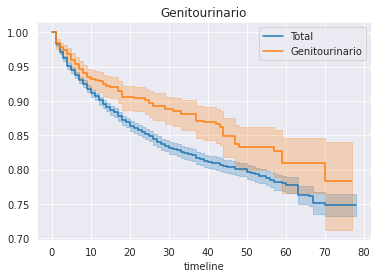

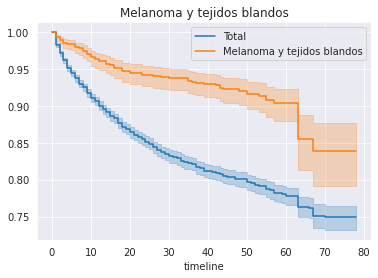

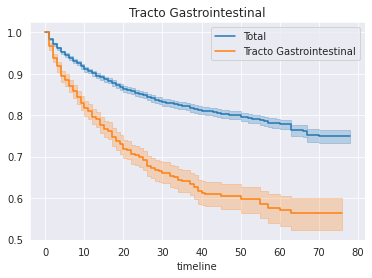

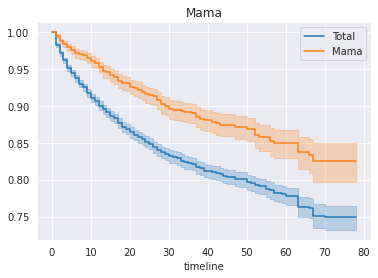

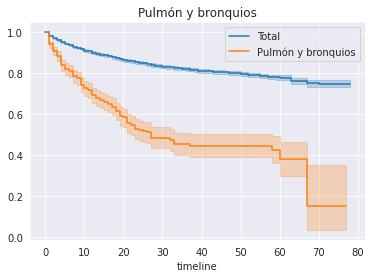

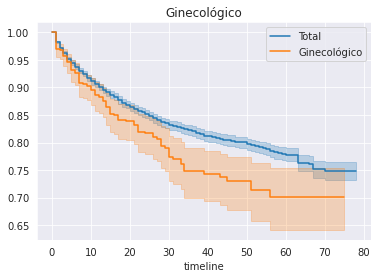

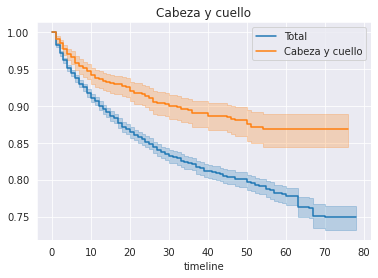

In [49]:
grupos = base_f['Grupo'].unique()
kmf = KaplanMeierFitter()
for g in grupos:
    # ax = plt.subplot(2, 4, i + 1)
    plt.figure()

    ix = base_f['Grupo'] == g
    kmf.fit(T[ix], E[ix], label=g)
    km_total.plot()
    kmf.plot()

    plt.title(g)
    # plt.xlim(0, 80)
    plt.savefig(f'Outputs/km_TotalVs{g}.png',bbox_inches='tight')



In [ ]:
na_total = NelsonAalenFitter()
na_total.fit(T,E, label='Total' )

## Cox proportional Hazzard

Dividir en base de entrenamiento y validación

In [72]:
from sklearn.model_selection import train_test_split
index_train, index_test = train_test_split( idx, test_size = 0.25)
index_train_gastro, index_test_gastro = train_test_split( idx_gastro, test_size = 0.25)
index_train_mama, index_test_mama = train_test_split( idx_mama, test_size = 0.25)


In [61]:
from pysurvival.models.semi_parametric import CoxPHModel

In [73]:
coxph_total = CoxPHModel()
coxph_total.fit(X.loc[index_train,:], T[index_train], E[index_train], init_method='zeros',verbose=True, lr=0.1)

Performing Newton-Raphson optimization
 * Iteration #1 - Loss = 10435.788 - ||grad||^2 = 1129.85833


 * Iteration #2 - Loss = 10339.733 - ||grad||^2 = 1007.05214
 * Iteration #3 - Loss = 10274.275 - ||grad||^2 = 903.17446


 * Iteration #4 - Loss = 10224.994 - ||grad||^2 = 811.15498
 * Iteration #5 - Loss = 10186.676 - ||grad||^2 = 729.13319


 * Iteration #6 - Loss = 10156.302 - ||grad||^2 = 655.77399
 * Iteration #7 - Loss = 10131.917 - ||grad||^2 = 590.02466


 * Iteration #8 - Loss = 10112.170 - ||grad||^2 = 531.01362
 * Iteration #9 - Loss = 10096.082 - ||grad||^2 = 477.99883


 * Iteration #10 - Loss = 10082.917 - ||grad||^2 = 430.33774
 * Iteration #11 - Loss = 10072.111 - ||grad||^2 = 387.46771


 * Iteration #12 - Loss = 10063.223 - ||grad||^2 = 348.89243
 * Iteration #13 - Loss = 10055.901 - ||grad||^2 = 314.17176


 * Iteration #14 - Loss = 10049.865 - ||grad||^2 = 282.91391
 * Iteration #15 - Loss = 10044.885 - ||grad||^2 = 254.76913


 * Iteration #16 - Loss = 10040.778 - ||grad||^2 = 229.42451
 * Iteration #17 - Loss = 10037.390 - ||grad||^2 = 206.59968


 * Iteration #18 - Loss = 10034.597 - ||grad||^2 = 186.04304
 * Iteration #19 - Loss = 10032.296 - ||grad||^2 = 167.52864


 * Iteration #20 - Loss = 10030.400 - ||grad||^2 = 150.85338
 * Iteration #21 - Loss = 10028.840 - ||grad||^2 = 135.83456


 * Iteration #22 - Loss = 10027.557 - ||grad||^2 = 122.30779
 * Iteration #23 - Loss = 10026.503 - ||grad||^2 = 110.12506


 * Iteration #24 - Loss = 10025.637 - ||grad||^2 = 99.15311
 * Iteration #25 - Loss = 10024.927 - ||grad||^2 = 89.27188


 * Iteration #26 - Loss = 10024.345 - ||grad||^2 = 80.37324
 * Iteration #27 - Loss = 10023.868 - ||grad||^2 = 72.35974


 * Iteration #28 - Loss = 10023.478 - ||grad||^2 = 65.14360
 * Iteration #29 - Loss = 10023.159 - ||grad||^2 = 58.64571


 * Iteration #30 - Loss = 10022.899 - ||grad||^2 = 52.79478
 * Iteration #31 - Loss = 10022.686 - ||grad||^2 = 47.52657


 * Iteration #32 - Loss = 10022.512 - ||grad||^2 = 42.78322
 * Iteration #33 - Loss = 10022.370 - ||grad||^2 = 38.51256


 * Iteration #34 - Loss = 10022.254 - ||grad||^2 = 34.66760
 * Iteration #35 - Loss = 10022.160 - ||grad||^2 = 31.20601


 * Iteration #36 - Loss = 10022.083 - ||grad||^2 = 28.08965
 * Iteration #37 - Loss = 10022.021 - ||grad||^2 = 25.28416


 * Iteration #38 - Loss = 10021.970 - ||grad||^2 = 22.75859
 * Iteration #39 - Loss = 10021.928 - ||grad||^2 = 20.48506


 * Iteration #40 - Loss = 10021.895 - ||grad||^2 = 18.43845
 * Iteration #41 - Loss = 10021.867 - ||grad||^2 = 16.59616


 * Iteration #42 - Loss = 10021.845 - ||grad||^2 = 14.93781
 * Iteration #43 - Loss = 10021.827 - ||grad||^2 = 13.44506


 * Iteration #44 - Loss = 10021.812 - ||grad||^2 = 12.10140
 * Iteration #45 - Loss = 10021.800 - ||grad||^2 = 10.89195


 * Iteration #46 - Loss = 10021.790 - ||grad||^2 = 9.80331
 * Iteration #47 - Loss = 10021.782 - ||grad||^2 = 8.82343


 * Iteration #48 - Loss = 10021.776 - ||grad||^2 = 7.94146
 * Iteration #49 - Loss = 10021.770 - ||grad||^2 = 7.14762


 * Iteration #50 - Loss = 10021.766 - ||grad||^2 = 6.43310
 * Iteration #51 - Loss = 10021.763 - ||grad||^2 = 5.78999


 * Iteration #52 - Loss = 10021.760 - ||grad||^2 = 5.21116
 * Iteration #53 - Loss = 10021.758 - ||grad||^2 = 4.69017


 * Iteration #54 - Loss = 10021.756 - ||grad||^2 = 4.22126
 * Iteration #55 - Loss = 10021.754 - ||grad||^2 = 3.79923


 * Iteration #56 - Loss = 10021.753 - ||grad||^2 = 3.41938
 * Iteration #57 - Loss = 10021.752 - ||grad||^2 = 3.07750


 * Iteration #58 - Loss = 10021.751 - ||grad||^2 = 2.76979
 * Iteration #59 - Loss = 10021.750 - ||grad||^2 = 2.49285


 * Iteration #60 - Loss = 10021.750 - ||grad||^2 = 2.24360
 * Iteration #61 - Loss = 10021.749 - ||grad||^2 = 2.01927


 * Iteration #62 - Loss = 10021.749 - ||grad||^2 = 1.81736
 * Iteration #63 - Loss = 10021.749 - ||grad||^2 = 1.63564


 * Iteration #64 - Loss = 10021.748 - ||grad||^2 = 1.47209
 * Iteration #65 - Loss = 10021.748 - ||grad||^2 = 1.32490
 * Iteration #66 - Loss = 10021.748 - ||grad||^2 = 1.19242


 * Iteration #67 - Loss = 10021.748 - ||grad||^2 = 1.07318
 * Iteration #68 - Loss = 10021.748 - ||grad||^2 = 0.96587


 * Iteration #69 - Loss = 10021.748 - ||grad||^2 = 0.86929
 * Iteration #70 - Loss = 10021.748 - ||grad||^2 = 0.78236


 * Iteration #71 - Loss = 10021.748 - ||grad||^2 = 0.70413
 * Iteration #72 - Loss = 10021.747 - ||grad||^2 = 0.63372


 * Iteration #73 - Loss = 10021.747 - ||grad||^2 = 0.57035
 * Iteration #74 - Loss = 10021.747 - ||grad||^2 = 0.51332


 * Iteration #75 - Loss = 10021.747 - ||grad||^2 = 0.46199
 * Iteration #76 - Loss = 10021.747 - ||grad||^2 = 0.41579


 * Iteration #77 - Loss = 10021.747 - ||grad||^2 = 0.37421
 * Iteration #78 - Loss = 10021.747 - ||grad||^2 = 0.33679


 * Iteration #79 - Loss = 10021.747 - ||grad||^2 = 0.30311
 * Iteration #80 - Loss = 10021.747 - ||grad||^2 = 0.27280


 * Iteration #81 - Loss = 10021.747 - ||grad||^2 = 0.24552
 * Iteration #82 - Loss = 10021.747 - ||grad||^2 = 0.22097


 * Iteration #83 - Loss = 10021.747 - ||grad||^2 = 0.19888
 * Iteration #84 - Loss = 10021.747 - ||grad||^2 = 0.17899


 * Iteration #85 - Loss = 10021.747 - ||grad||^2 = 0.16109
 * Iteration #86 - Loss = 10021.747 - ||grad||^2 = 0.14498


 * Iteration #87 - Loss = 10021.747 - ||grad||^2 = 0.13048
 * Iteration #88 - Loss = 10021.747 - ||grad||^2 = 0.11744


 * Iteration #89 - Loss = 10021.747 - ||grad||^2 = 0.10569
 * Iteration #90 - Loss = 10021.747 - ||grad||^2 = 0.09512


 * Iteration #91 - Loss = 10021.747 - ||grad||^2 = 0.08561
 * Iteration #92 - Loss = 10021.747 - ||grad||^2 = 0.07705


 * Iteration #93 - Loss = 10021.747 - ||grad||^2 = 0.06934
 * Iteration #94 - Loss = 10021.747 - ||grad||^2 = 0.06241


 * Iteration #95 - Loss = 10021.747 - ||grad||^2 = 0.05617
 * Iteration #96 - Loss = 10021.747 - ||grad||^2 = 0.05055


 * Iteration #97 - Loss = 10021.747 - ||grad||^2 = 0.04550
 * Iteration #98 - Loss = 10021.747 - ||grad||^2 = 0.04095


 * Iteration #99 - Loss = 10021.747 - ||grad||^2 = 0.03685
 * Iteration #100 - Loss = 10021.747 - ||grad||^2 = 0.03317
Optimization reached max number of iterations.


CoxPHModel

In [ ]:
coxph_gastro = CoxPHModel()
coxph_gastro.fit(X.loc[index_train_gastro,:], T[index_train_gastro], E[index_train_gastro], init_method='zeros',verbose=True, lr=0.5)

In [ ]:
coxph_mama = CoxPHModel()
coxph_mama.fit(X.loc[index_train_mama,:], T[index_train_mama], E[index_train_mama], init_method='zeros',verbose=True, lr=0.1)

In [ ]:
out_path = 'Outputs/'
coxph_total.save(out_path+'super_coxph_total.zip')
coxph_gastro.save(out_path+'super_coxph_gastro.zip')
coxph_mama.save(out_path+'super_coxph_total.zip')


In [74]:
coxph_total.summary.sort_values(by='p_values').head(7).to_latex('Outputs/CoxPHTotal.tex')

In [ ]:
coxph_gastro.summary.sort_values(by='p_values').head(6)

In [ ]:
coxph_mama.summary.sort_values(by='p_values').head()

In [76]:
from pysurvival.utils.metrics import concordance_index
from pysurvival.utils.display import integrated_brier_score


In [77]:
c_index_cox_total = concordance_index(coxph_total,X.loc[index_test,:], T[index_test], E[index_test])
print('C-index: {:.3f}'.format(c_index_cox_total))

C-index: 0.708


In [ ]:
c_index_cox_gastro = concordance_index(coxph_gastro,X.loc[index_test_gastro,:], T[index_test_gastro], E[index_test_gastro])
print('C-index: {:.3f}'.format(c_index_cox_gastro))

In [ ]:
c_index_cox_mama = concordance_index(coxph_mama,X.loc[index_test_mama,:], T[index_test_mama], E[index_test_mama])
print('C-index: {:.3f}'.format(c_index_cox_mama))

In [83]:
ibs = integrated_brier_score(coxph_mama, X.loc[index_test_mama,:], T[index_test_mama], E[index_test_mama], t_max=100,
            figure_size=(20, 6.5) )
print('IBS: {:.2f}'.format(ibs))

NameError: name 'coxph_mama' is not defined

## Random Survival forest

In [78]:
from pysurvival.models.survival_forest import ConditionalSurvivalForestModel
from pysurvival.models.survival_forest import RandomSurvivalForestModel

## elección condicional de puntos de corte

In [79]:
%%time
csf = ConditionalSurvivalForestModel(num_trees=40)
csf.fit(X.loc[index_train,:], T[index_train], E[index_train], max_features='sqrt',
        max_depth=5, min_node_size=20, alpha=0.05, minprop=0.1)

CPU times: user 1min 21s, sys: 82 ms, total: 1min 21s
Wall time: 11.1 s


ConditionalSurvivalForestModel

In [81]:
csf.variable_importance_table.head().to_latex('Outputs/RFcTotal.tex')

In [82]:
c_index_csf_total = concordance_index(csf,X.loc[index_test,:], T[index_test], E[index_test])
print('C-index: {:.3f}'.format(c_index_csf_total))

C-index: 0.661


In [ ]:
csf_gastro = ConditionalSurvivalForestModel(num_trees=40)
csf_gastro.fit(X.loc[index_train_gastro,:], T[index_train_gastro], E[index_train_gastro], max_features='sqrt',
        max_depth=5, min_node_size=20, alpha=0.05, minprop=0.1)

In [ ]:
csf_gastro.variable_importance_table

In [ ]:
c_index_csf_gastro = concordance_index(csf,X.loc[index_test_gastro,:], T[index_test_gastro], E[index_test_gastro])
print('C-index: {:.3f}'.format(c_index_csf_gastro))

## seleccion aleatoria de cortes

In [ ]:
rsf = RandomSurvivalForestModel(num_trees=40)
rsf.fit(X.loc[index_train,:], T[index_train], E[index_train], max_features='sqrt',
        max_depth=5, min_node_size=20)

In [ ]:
rsf.variable_importance_table.head(4).to_latex(out_path+"tabla_2.tex", index=False)

In [ ]:
c_index = concordance_index(rsf,X.loc[index_test,:], T[index_test], E[index_test])
print('C-index: {:.3f}'.format(c_index))


In [ ]:
%aimport extraer.marcadores
import extraer.marcadores as ex
